将原来的py代码修改为notebook中实现，方便调试和数据可视化

In [1]:
#模块导入
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import sklearn.preprocessing as preprocessing
import numpy as np
from sklearn.ensemble import BaggingRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
%matplotlib inline

class FeatureEngineerTools:
    '''特征工程工具包.
    
    机器学习过程，特征工程步骤需要使用的常用分析工具的整理打包。

    Attribute
    
    Function
    show_contin_columns:连续取值数据的观察（绘图）.
    show_corr_int_label:观察data数据columns各维度和label字段的相关度
    show_corr_contin_label:观察data的连续数据列column和label的相关度
    show_corr_disper_label:观察data的离散数据列column和label的相关度
    columns_enum_to_int:将数据集中的枚举变量转int数值.
    columns_dummies：将数据集中的多值列做onehot处理
    column_set_missing_label:使用data数据columns中维度来填充label字段的缺失信息
    show_learning_curve:画出data在某模型上的learning curve.
    heatmap:观察data的相关度热力图
    '''
    @staticmethod
    def show_contin_columns(data,columns=[]):
        ''' 连续取值数据的观察（绘图）.
        
        Param
        data:需要观察的数据集
        columns:观察的数据列
        
        Return（None）
        '''
    
        fig = plt.figure()
        fig.set(alpha=0.2)  # 设定图表颜色alpha参数
        for i in range(0,len(columns)):
            fig.add_subplot(len(columns) * 100 + 10 + 1 + i)  # 最后一位编码从0开始，但是实际sbuplot需要从1开始
            column_name = columns[i]
            data[column_name].plot(kind='kde')
            plt.title(column_name)
        plt.show()
        plt.close()
    
    @staticmethod
    def columns_enum_to_int(data_train,data_test=None,columns=[]):
        '''将数据集中的枚举变量转int数值.
        
        Param
        data_train：DataFrame。训练数据集
        data_test：DataFrame。测试数据集
        columns：List<String>。需要转化为int的列标签
        
        Return
        data_train：DataFrame。转化后的训练数据集
        data_test：转化后的测试数据集
        '''
        for i in range(0, len(columns)):
            column_name = columns[i]
            column_le = LabelEncoder().fit(data_train[column_name])
            column_label = column_le.transform(data_train[column_name])
            data_train[column_name] = column_label
            if data_test:
                column_label = column_le.transform(data_test[column_name])
                data_test[column_name] = column_label
            print ('Function columns_enum_to_int ',column_name+' ',column_le.classes_)
     
        return data_train,data_test

    @staticmethod
    def columns_dummies(data_train,data_test=None,columns=[],drop=True):
        '''将数据集中的多值列做onehot处理.
        
        对列属性做onehot处理
        例如：列label，取值空间：[1,2,3]处理后新列为label_1,label_2,label_3,默认自动drop掉原列label
        数据中的nan会自动填充为字符“NAN”，所以label中的确是值为列label_NAN
        
        Param
        data_train：DataFrame。训练数据集
        data_test：DataFrame。测试数据集
        columns：List<String>。需要转化为onehot的列标签
        drop:boolean。自动丢弃原列
        
        Return
        data_train：DataFrame。转化后的训练数据集
        data_test：转化后的测试数据集
        '''
        data_train.fillna('NAN')
        if data_test:
            data_test.fillna('NAN')
        for i in range(0,len(columns)):
            column_name=columns[i]
            dummies_column = pd.get_dummies(data_train[column_name], prefix=column_name)
            data_train = pd.concat([data_train, dummies_column], axis=1)
            if drop:
                data_train.drop([column_name], axis=1, inplace=True)
            if data_test:
                dummies_column = pd.get_dummies(data_test[column_name], prefix=column_name)
                data_test = pd.concat([data_test, dummies_column], axis=1)
                if drop:
                    data_test.drop([column_name], axis=1, inplace=True)
        return data_train,data_test
    
    @staticmethod
    def columns_set_missing_label(data,columns=[],label='',algo=None):
        '''使用data数据columns中维度来填充label字段的缺失信息,采用算法algo.
        
        Param
        data：DataFrame。填充数据集
        columns：List<String>。需要训练模型的数据列
        label:String。需要填充的列
        
        Return
        data：DataFrame。填充缺失值后的数据集
        algo：填充算法，可用于对其他数据集进行填充
        '''
        if algo is None:
            algo=RandomForestRegressor()

        # 把已有的数值型特征取出来丢进Random Forest Regressor中
        data_tmp=data[columns+[label]]

        data_train=data_tmp.loc[data_tmp[label].notnull()]
        data_test=data_tmp.loc[data_tmp[label].isnull()]
        # print data_tmp[label].isnull()
        train_x=data_train[columns]
        train_y=data_train[label]
        test_x=data_test[columns]
        algo.fit(train_x,train_y)
        test_y=algo.predict(test_x)
        data.loc[(data[label].isnull()),label]=test_y
        return data,algo


    @staticmethod
    def show_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1,
                            train_sizes=np.linspace(.05, 1., 20), verbose=0, plot=True):
        """画出data在某模型上的learning curve.
        
        用sklearn的learning_curve得到training_score和cv_score，使用matplotlib画出learning curve
        
        Param
        estimator: 使用的分类器。
        title : 表格的标题。
        X : 输入的feature，numpy类型
        y : 输入的target vector
        ylim : tuple格式的(ymin, ymax), 设定图像中纵坐标的最低点和最高点
        cv : 做cross-validation的时候，数据分成的份数，其中一份作为cv集，其余n-1份作为training(默认为3份)
        n_jobs : 并行的的任务数(默认1)

        Return
        midpoint:TODO
        diff:TODO
        """
        train_sizes, train_scores, test_scores = learning_curve(
            estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        if plot:
            plt.figure()
            plt.title(title)
            if ylim is not None:
                plt.ylim(*ylim)
            plt.xlabel(u"训练样本数")
            plt.ylabel(u"得分")
            plt.gca().invert_yaxis()
            plt.grid()

            plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std,
                             alpha=0.1, color="b")
            plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std,
                             alpha=0.1, color="r")
            plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"训练集上得分")
            plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"交叉验证集上得分")

            plt.legend(loc="best")

            plt.draw()
            plt.gca().invert_yaxis()
            plt.show()

        midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
        diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
        return midpoint, diff
    
    @staticmethod
    def show_corr_int_label(data, column, label=''):
        '''观察data数据columns各维度和label字段的相关度.
        
        通过柱状图来实现。不是真实的相关性计算。
        绘制柱状图
        第一副：column的各取值上lable取值的分布，可以看到column和lable是否有关联
        第二副：含义和上图相同，但展示的是百分比数据，当数据分布不均衡时比图一更能体现关联特征
        
        Param
        data：DataFrame。数据集
        columns：List<String>。需要观察的数据列
        label:String。标签列（预测的目标列）
        
        Return（None）
        '''
        fig = plt.figure()
        fig.set(alpha=0.2) 
        data[label]=data[label].apply(lambda x:int(x))
        value_set = data[label].value_counts().keys()

        # 对lable的每一个取值,依次过滤，value_counts中map的key为展示图内部的柱体含义描述
        value_counts = {}
        for label_value in value_set:
            value_counts.update(
                {'label_' + str(label_value): data[data[label] == label_value][column].value_counts()})

        df = pd.DataFrame(value_counts)
        df.plot(kind='bar', stacked=True)
        plt.title(column)
        plt.xlabel(column + "_value")
        plt.ylabel(column + "_counts")
        plt.show()

        for index_name in df.index:
            df.loc[index_name].fillna(0,inplace=True)
            df.loc[index_name]=df.loc[index_name]*1.0/df.loc[index_name].sum()

        df.plot(kind='bar', stacked=True)
        plt.title(column)
        plt.xlabel(column + "_value")
        plt.ylabel(column + "_counts")
        plt.show()
    
    @staticmethod
    def show_corr_contin_label(data,column,label=''):
        '''观察data的连续数据列column和label的相关度.
        
        通过柱状图来实现。不是真实的相关性计算。
        
        Param
        data：DataFrame。数据集
        columns：String。需要观察的数据列
        label:String。标签列（预测的目标列）
        
        Return（None）
        '''
        fig = plt.figure()
        fig.set(alpha=0.2)  # 设定图表颜色alpha参数
        label_value_set=data[label].value_counts().keys()
        for label_value in label_value_set:
            data[column][data[label] == label_value].plot(kind='kde')
        plt.xlabel("column")  # plots an axis lable
        plt.ylabel(u"密度")
        plt.title(u"密度分布"+column)
        plt.legend(str(label_value_set), loc='best')  # sets our legend for our graph.
        plt.show()

    @staticmethod
    def show_corr_disper_label(data,column,label):
        '''观察data的离散数据列column和label的相关度.
        
        通过柱状图来实现。不是真实的相关性计算。
        
        Param
        data：DataFrame。数据集
        column：String。需要观察的数据列
        label:String。标签列（预测的目标列）
        
        Return（None）
        '''
        #print (data_train[[column_name, label]].groupby([column_name], as_index=False).mean())
        value_set = data[label].value_counts().keys()
        value_counts = {}
        for label_value in value_set:
            value_counts.update(
                {'label_' + str(label_value): data[data_train[label] == label_value][column].value_counts()})
        df = pd.DataFrame(value_counts)
        df=df.sort_index(axis=0, by=None, ascending=True)
        df.plot(kind='bar', stacked=True)
        plt.title(column)
        plt.xlabel(column + "_value")
        plt.ylabel(column + "_counts")
        plt.show()

        #每列调整为100%
    #     for index_name in df.index:
    #         df.loc[index_name].fillna(0,inplace=True)
    #         df.loc[index_name]=df.loc[index_name]*1.0/df.loc[index_name].sum()
        df['__label_sum__']=df.sum(axis=1)
        for col_name in df.columns:
            df[col_name]=df[col_name]*1.0/df['__label_sum__']
        df=df.drop(['__label_sum__'],axis=1)
        df.plot(kind='bar', stacked=True)
        plt.title(column)
        plt.xlabel(column+ "_value")
        plt.ylabel(column+ "_counts")
        plt.show()
        
    @staticmethod    
    def heatmap(data,columns=[]):
        '''观察data的相关度热力图.
        
        Param
        data：DataFrame。数据集
        column：String。需要观察的数据列
        
        Return（None）
        '''
        import seaborn as sns
        colormap = plt.cm.viridis
        plt.figure(figsize=(14,12))
        plt.title('Pearson Correlation of Features', y=1.05, size=15)
        if not any(columns):
            columns=data.columns
        sns.heatmap(data[columns].astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

    @staticmethod
    def combineFeature(df,columns=[]): 
        '''遍历所有可能的组合.
        
        每一维特征权重应当同权，都应当scaled 
        '''
        print("Starting With",df.columns.size,"手动生成组合特征",columns)  
        #只考虑连续属性同时标准化过的属性  
        if not any(columns):
            columns=df.columns.values
        numerics = df.loc[:,columns]
        print("\nFeatures used for automated feature generation:\n",numerics.head(10))  

        new_fields_count = 0  
        for i in range(0,numerics.columns.size - 1):  
            for j in range(0,numerics.columns.size-1):  
                if i<=j:  
                    name = str(numerics.columns.values[i]) + "*" + str(numerics.columns.values[j])  
                    df = pd.concat([df,pd.Series(numerics.iloc[:,i]*numerics.iloc[:,j],name=name)],axis=1)  
                    new_fields_count+=1  
                if i<j:  
                    name = str(numerics.columns.values[i]) + "+" + str(numerics.columns.values[j])  
                    df = pd.concat([df, pd.Series(numerics.iloc[:, i] + numerics.iloc[:, j], name=name)], axis=1)  
                    new_fields_count += 1  
                if not i == j:  
                    name = str(numerics.columns.values[i]) + "/" + str(numerics.columns.values[j])  
                    df = pd.concat([df, pd.Series(numerics.iloc[:, i] / numerics.iloc[:, j], name=name)], axis=1)  
                    name = str(numerics.columns.values[i]) + "-" + str(numerics.columns.values[j])  
                    df = pd.concat([df, pd.Series(numerics.iloc[:, i] - numerics.iloc[:, j], name=name)], axis=1)  
                    new_fields_count += 2  
        print("\n",new_fields_count,"new features generated")  
        return df  
        
class AlgoAssemTools:
    '''算法的选择评估工具类.
    
    Function
    get_oof:评估二分类算法的预测准确率
    eval_clf_accuracy_score:对二分类器按照accuracy_score的规则打分
    '''
    @staticmethod
    def get_oof(clf, x_train, y_train, x_test, n_folds=10, random_state=0):
        '''评估二分类算法的预测准确率.
        
        Param
        clf：算法，需提供接口train(),predict()
        x_train:训练数据的学习字段
        y_train:训练数据的预测字段
        x_test:测试数据的学习字段
        n_flolds:学习时的预测规模比例，或学习次数，比如10，每次学习0.9预测x_train的0.1,同时预测x_test.
        最终得到的x_train会有一份完整的预测，x_test多组（这里是10）最终中取平均值
        random_state:kflod初始化时的随机种子
        
        Return
        oof_train:在训练集合上的预测结果
        oof_test:在测试集上的预测结果
        '''
        ntrain=len(x_train)
        ntest=len(x_test)
        kf = KFold(ntrain,n_folds=n_folds, shuffle=True, random_state=random_state)
        oof_train = np.zeros((ntrain,))
        oof_test = np.zeros((ntest,))
        oof_test_skf = np.empty((n_folds, ntest))

        for i, (train_index, test_index) in enumerate(kf):
            x_tr = x_train[train_index]
            y_tr = y_train[train_index]
            x_te = x_train[test_index]

            clf.fit(x_tr, y_tr)

            oof_train[test_index] = clf.predict(x_te)
            oof_test_skf[i, :] = clf.predict(x_test)

        oof_test[:] = oof_test_skf.mean(axis=0)
        return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)
    
    @staticmethod
    def eval_clf_accuracy_score(clf,train_data,train_label,n_splits=10):
        '''对二分类器按照accuracy_score的规则打分.
        
        Param
        clf：分类器
        train_data:训练数据的学习部分
        train_label:训练数据的标签部分
        n_splits:学习比例或学习次数，比如10,每次学习train_data的0.9，模型预测0.1,打分。循环10次可将train_data所有数据都作为
        测试数据预测一遍。每次的模型预测的0.1部分计算准确率，10次取平均返回
        
        Return
        acc_score:分类器在训练数据上的自打分分数
        '''
        sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=1.0/n_splits, random_state=0)
        acc_score=0.0
        for train_index, test_index in sss.split(train_data, train_label):
            X_train, X_test = train_data[train_index], train_data[test_index]
            y_train, y_test = train_label[train_index], train_label[test_index]
            clf.fit(X_train, y_train)
            train_predictions = clf.predict(X_test)
            acc = accuracy_score(y_test, train_predictions)
            acc_score+=acc
        acc_score=acc_score/n_splits
        return float(acc_score)
    
    @staticmethod
    def eval_clfs_accuracy_score(clfs,train_data,train_label,n_splits=10):
        '''对二分类器按照accuracy_score的规则打分.
        
        Param
        clfs：分类器[]
        train_data:训练数据的学习部分
        train_label:训练数据的标签部分
        n_splits:学习比例或学习次数，比如10,每次学习train_data的0.9，模型预测0.1,打分。循环10次可将train_data所有数据都作为
        测试数据预测一遍。每次的模型预测的0.1部分计算准确率，10次取平均返回
        
        Return
        acc_dict:dict(),分类器在训练数据上的自打分分数，key为分类器名称，value为准确率
        '''
        acc_dict={}
        for clf in clfs:
            clf_score=AlgoAssemTools.eval_clf_accuracy_score(clf,train_data,train_label,10)
            acc_dict[clf]=clf_score
        return acc_dict

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:
#load原始CSV数据
print ('Read Data From File')
FILE_DIR='/media/john/10167DFA167DE0E0/TDDOWNLOAD/ML/titanic/officialData'

data_train = pd.read_csv('{0}/train.csv'.format(FILE_DIR))
data_test=pd.read_csv('{0}/test.csv'.format(FILE_DIR))

Read Data From File


/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:61: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python2.7/dist-packages

Feature Perprocessing
('Function columns_enum_to_int ', 'Sex ', array(['female', 'male'], dtype=object))
('Function columns_enum_to_int ', 'Embarked ', array(['C', 'Q', 'S'], dtype=object))
('Function columns_enum_to_int ', 'Title ', array(['Master', 'Miss', 'Mr', 'Mrs', 'Rare'], dtype=object))
('Function columns_enum_to_int ', 'Fare ', array([Interval(-0.001, 7.75, closed='right'),
       Interval(7.75, 7.8959999999999999, closed='right'),
       Interval(7.8959999999999999, 10.007999999999999, closed='right'),
       Interval(10.007999999999999, 14.454000000000001, closed='right'),
       Interval(14.454000000000001, 24.149999999999999, closed='right'),
       Interval(24.149999999999999, 31.274999999999999, closed='right'),
       Interval(31.274999999999999, 69.549999999999997, closed='right'),
       Interval(69.549999999999997, 512.32899999999995, closed='right')], dtype=object))
    Age     Cabin  Embarked  Fare  Name  Parch  PassengerId  Pclass  Sex  \
0  22.0 -0.420654        

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:107: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


('Function columns_enum_to_int ', 'Age ', array([  0.17      ,   0.33      ,   0.42      ,   0.67      ,
         0.75      ,   0.83      ,   0.92      ,   1.        ,
         2.        ,   3.        ,   3.5177    ,   3.77267   ,
         4.        ,   4.66379167,   5.        ,   5.34413952,
         5.36708333,   5.72012   ,   5.97114095,   6.        ,
         7.        ,   8.        ,   8.26664833,   9.        ,
         9.13067   ,   9.37681   ,   9.719275  ,  10.        ,
        11.        ,  11.5       ,  11.5571    ,  12.        ,
        12.43725   ,  13.        ,  13.41057833,  14.        ,
        14.5       ,  14.86929202,  14.875025  ,  15.        ,
        16.        ,  16.19526   ,  16.5305    ,  17.        ,
        18.        ,  18.11981071,  18.269625  ,  18.47276012,
        18.5       ,  18.96092024,  19.        ,  19.00726905,
        19.74644921,  19.96320714,  20.        ,  20.17110595,
        20.30708095,  20.42150687,  20.5       ,  20.5115496 ,
        20.64

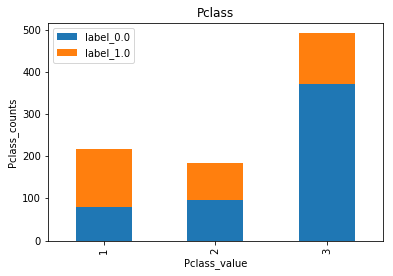

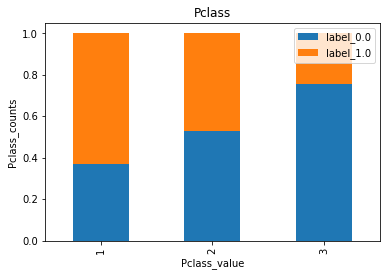

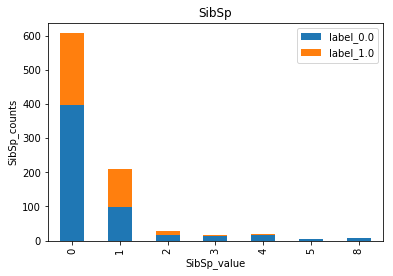

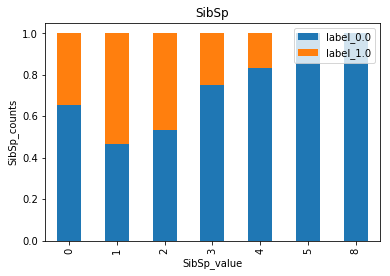

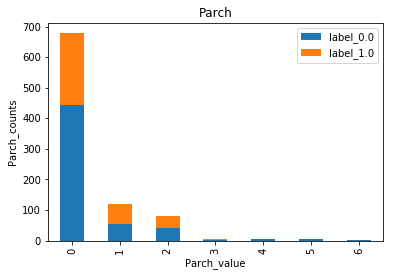

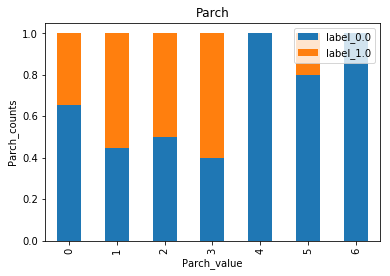

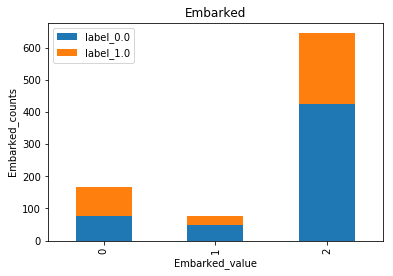

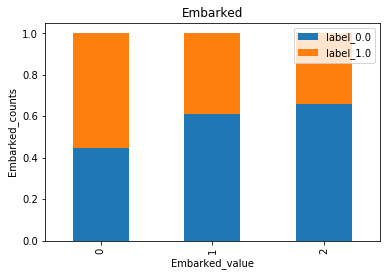

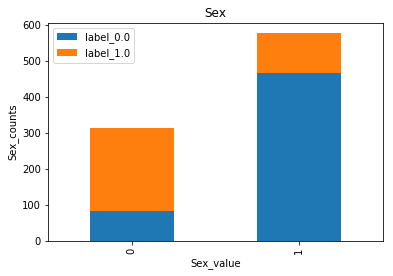

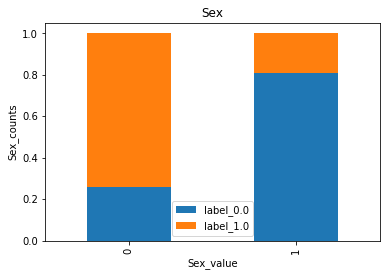

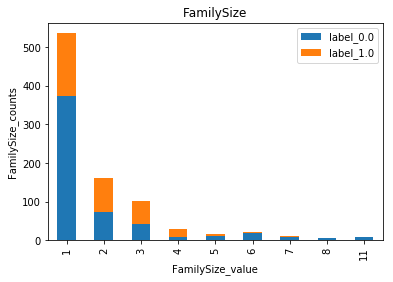

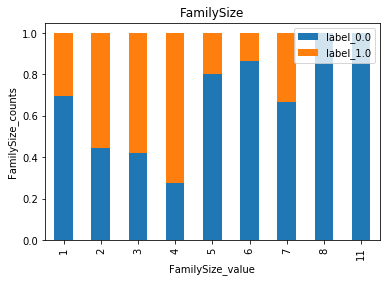

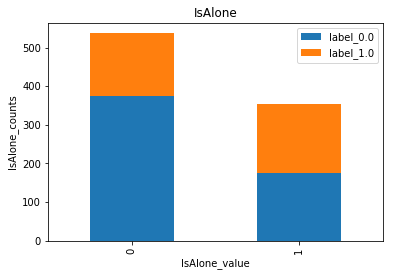

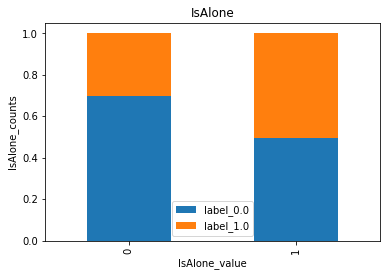

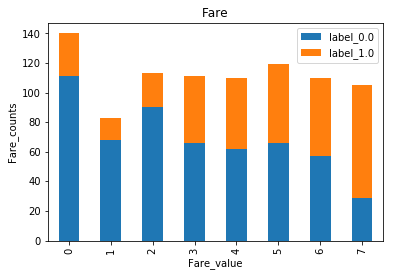

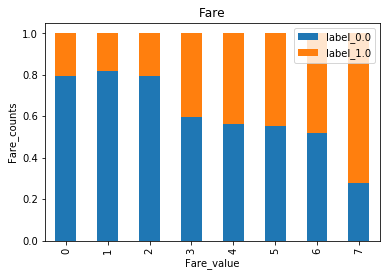

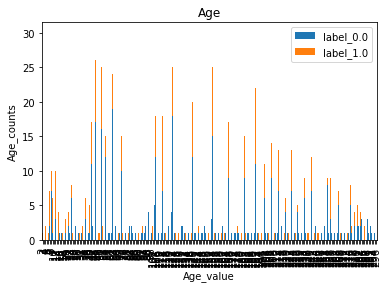

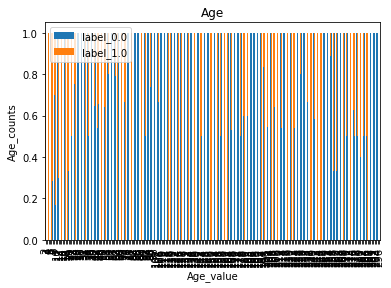

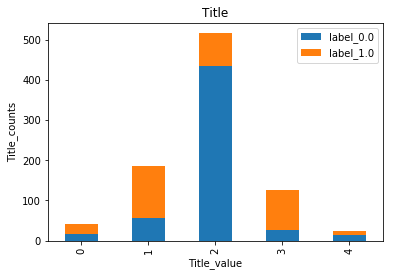

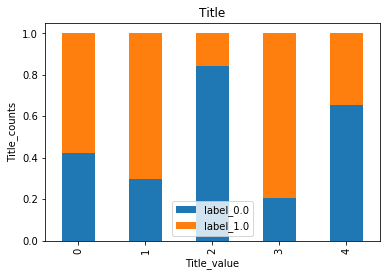

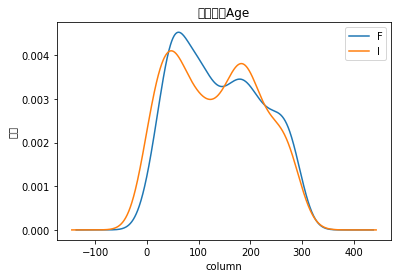

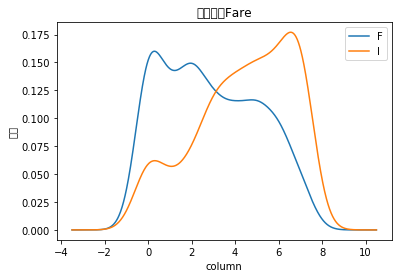

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


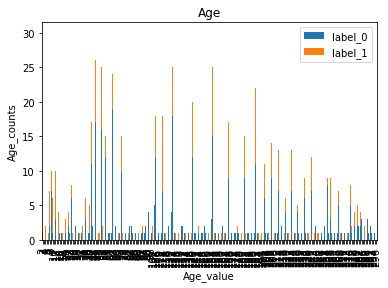

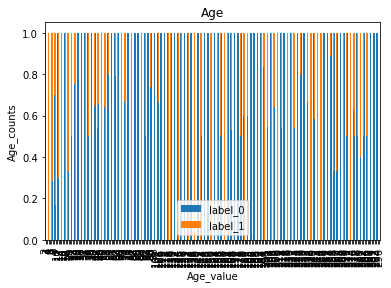

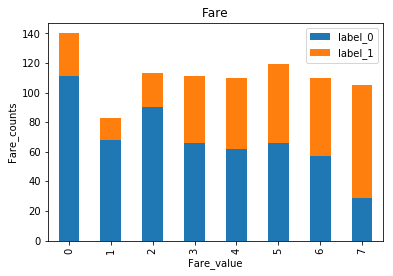

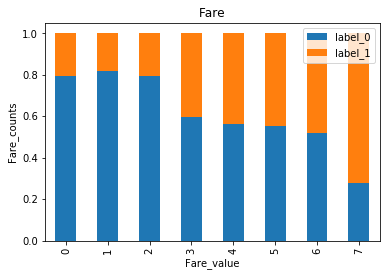

In [3]:
import re as re
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
print ('Feature Perprocessing')

train_passengerId=data_train['PassengerId']
test_passengerId=data_test['PassengerId']
data_full=data_train.append(data_test, ignore_index=True)

# print full_data.shape
# print full_data.head()
# print full_data.tail()
data_full['SibSp']=data_full['SibSp'].fillna(0)
data_full['Parch']=data_full['Parch'].fillna(0)
data_full['FamilySize'] = data_full['SibSp'] + data_full['Parch'] + 1
data_full['IsAlone'] = data_full.apply(lambda x:0 if x['FamilySize']==1 else 1,axis=1)
data_full['Embarked'] = data_full['Embarked'].fillna('S')
data_full['Fare'] = data_full['Fare'].fillna(data_train['Fare'].median())
data_full['Fare'] = pd.qcut(data_full['Fare'], 8)


def get_title(name):
	title_search = re.search(' ([A-Za-z]+)\.', name)
	# If the title exists, extract and return it.
	if title_search:
		return title_search.group(1)
	return ""

data_full['Title'] = data_full['Name'].apply(get_title)
data_full['Title'] = data_full['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare').replace('Mlle', 'Miss').replace('Ms', 'Miss').replace('Mme', 'Mrs')
data_full['Title'] = data_full['Title'].fillna(0)
data_full['Name'] = data_full['Name'].apply(len)

#todo
#Cabin有很多缺省值  
#发现是否缺省对结果影响很大  
#同时参数贡献度不够的说明划分不够细  
#能代表着一些隐含信息。比如船舱号Cabin这一属性，缺失可能代表并没有船舱  
#发现字母跟等级有关  
def getCabinLetter(cabin):  
    match = re.compile("([a-zA-Z]+)").search(cabin)  
    if match:  
        return  match.group()  
    else:  
        return 'U'  
  
def getCabinNumber(cabin):  
    match = re.compile("([0-9]+)").search(cabin)  
    if match:  
        return match.group()  
    else:  
        return 0  

data_full['Cabin'][data_full.Cabin.isnull()] = 'U0'  
data_full['CabinLetter'] = data_full['Cabin'].map(lambda x:getCabinLetter(x))  
data_full['CabinLetter'] = pd.factorize(data_full['CabinLetter'])[0]  
data_full['CabinNumber'] = data_full['Cabin'].map(lambda x:getCabinNumber(x)).astype(int) + 1 #0太多  
#std比较大所以我们要标准化  
sclar = preprocessing.StandardScaler()  
data_full['Cabin'] = sclar.fit_transform(data_full['CabinNumber'] .reshape(-1,1) )

# data_full['Cabin'] = data_full["Cabin"].apply(lambda x: 0 if type(x) == float else 1)


import re  
def getTicketPrefix(ticket):  
    match = re.compile("([a-zA-Z\.\/]+)").search(ticket)  
    if match:#有前缀  
        return match.group()  
    else:#没有前缀  
        return 'U'  
  
#获取票的数字  
def getTicketNumber(ticket):  
    match = re.compile("([0-9]+$)").search(ticket)  
    if match:  
        return  match.group()  
    else:  
        return '0'  
  

data_full['TicketPrefix'] = data_full['Ticket'].map(lambda x: getTicketPrefix(x.upper()))  
data_full['TicketPrefix'] = data_full['TicketPrefix'].map(lambda x: re.sub('[\.?\/?]', '', x))  # 去掉./  
data_full['TicketPrefix'] = data_full['TicketPrefix'].map(lambda x: re.sub('STON', 'SOTON', x))  
data_full['TicketPrefix'] = pd.factorize(data_full['TicketPrefix'])[0]  

data_full['TicketNumber'] = data_full['Ticket'].map(lambda x: getTicketNumber(x))  
data_full['TicketNumberLength'] = data_full['TicketNumber'].map(lambda x: len(x)). astype(int)  
data_full['TicketNumberStart'] = data_full['TicketNumber'].map(lambda x: x[0:1]).astype(int)  
data_full['TicketNumber'] = data_full['TicketNumber'].astype(int)  
#有可能跟票号有关系但是这个数显然不是标准属性  
scaler = preprocessing.StandardScaler()  
data_full['TicketNumber'] = scaler.fit_transform(data_full['TicketNumber'].reshape(-1,1))


FeatureEngineerTools.columns_enum_to_int(data_train=data_full,columns=['Sex','Embarked','Title','Fare'])
# data_full['Age'] = data_full['Age'].astype(int)
# data_full['Age'] = pd.qcut(data_full['Age'], 5)
# data_full['Age'] = data_full['Age'].fillna(data_train['Age'].median())

# #Age使用随机森林进行预测
print data_full.head(3)
data_full,algo=FeatureEngineerTools.columns_set_missing_label(data_full,\
                columns=['Cabin','Embarked','Fare','Name' ,'Parch','Pclass' ,'Sex','SibSp','FamilySize','IsAlone','Title'],label='Age',algo=RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1))

# data_full['Age'] = pd.cut(data_full['Age'],8)
data_full['Age_scaled'] = scaler.fit_transform(data_full['Age'].reshape(-1,1))

FeatureEngineerTools.columns_enum_to_int(data_train=data_full,columns=['Age'])

data_train=data_full[data_full['PassengerId'].isin(train_passengerId)]
data_test=data_full[data_full['PassengerId'].isin(test_passengerId)]
print data_train.head(1)
print data_test.head(1)

#属性和分类目标的相关性
columns=['Pclass','SibSp','Parch','Embarked','Sex','FamilySize','IsAlone','Fare','Age','Title']
label='Survived'
for column in columns:
    FeatureEngineerTools.show_corr_disper_label(data_train,column,label)

columns=['Age','Fare']
label='Survived'
for column in columns:
    FeatureEngineerTools.show_corr_contin_label(data_train,column,label)

for column in columns:
    FeatureEngineerTools.show_corr_int_label(data_train,column,label)


Feature Relevance And Selection
   Age     Cabin  Embarked  Fare  Name  Parch  Pclass  Sex  SibSp  Survived  \
0   66 -0.420654         2     0    23      0       3    1      1         0   
1  201  2.843455         0     7    51      0       1    0      1         1   
2  105 -0.420654         2     2    22      0       3    0      0         1   

   FamilySize  IsAlone  Title  CabinLetter  CabinNumber  TicketPrefix  \
0           2        1      2            0            1             0   
1           2        1      3            1           86             1   
2           1        0      1            0            1             2   

   TicketNumber  TicketNumberLength  TicketNumberStart  Age_scaled  
0     -0.412343                   5                  2   -0.583138  
1     -0.417967                   5                  1    0.583843  
2      4.437068                   7                  3   -0.291393  
     Age     Cabin  Embarked  Fare  Name  Parch  Pclass  Sex  SibSp  Survived  \
8

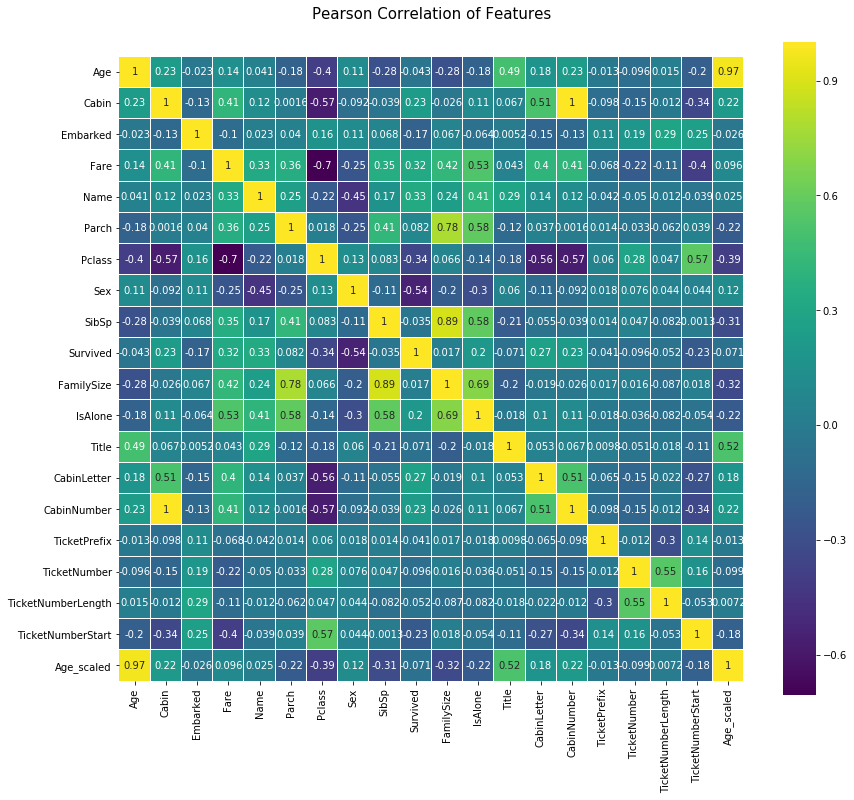

In [4]:
#todo
#数据规约和降低维度  
# 数据规约维度 PCA+ KMeans  
# 但仍接近于保持原始数据的完整性。也就是说，在归约后的数据集上进行数据挖掘将更加有效，仍然产生几乎相同的数据分析结果。  
# PCA通过创建一个替换的较小的变量集组合属性的基本要素  
# 规约有属性和数值  

#特征提取降低维度  
from sklearn.decomposition import PCA 

def processDrops(df,columns=[]):  
    '''标准化过的属性会在后续协方差中删除.
    
    '''
    if not any(columns):
        columns = df.columns.value

    #发现排除survived 和passengerId以后的子列  
    df_corr = df[columns].corr(method='spearman')  
    mask = np.ones(df_corr.columns.size) - np.eye(df_corr.columns.size)#默认中间为0相当于跟自己无关  
    df_corr = mask * df_corr#乘是对应元素乘  
    #得到整体的协方差矩阵  
  
    #赛选出相关性太高的属性冗杂属性  
    drops = []  
    for col in df_corr.columns.values:  
        if np.in1d([col],drops):#已经有了  
            continue  
        corr = df_corr[abs(df_corr[col]) > 0.98].index#第col列中相关性太大的舍弃  
        drops = np.union1d(drops, corr)  
    print("\nDropping", drops.shape[0], "highly correlated features...\n")# , drops  
    return  df.drop(drops,axis=1) 

print ('Feature Relevance And Selection')
drop_elements = ['PassengerId', 'Ticket']
data_train_org=data_train.copy()
data_test_org=data_test.copy()
data_train = data_train.drop(drop_elements, axis = 1)
data_test  = data_test.drop(drop_elements, axis = 1)

y_train = data_train[label].values
x_train=data_train.drop(label,axis=1).values
x_test = data_test.drop(label,axis=1).values


print data_train.head(3)
print data_test.head(3)
FeatureEngineerTools.heatmap(data_train)

# #使用pca进行维度简化
pca = PCA(n_components=0.99)
X_transformed = pca.fit_transform(x_train,y_train)  
# Create a data frame from the PCA'd data  
data_train = pd.DataFrame(X_transformed)
data_test= pd.DataFrame(pca.transform(x_test))
x_train=data_train.values
x_test=data_test.values


In [5]:
print len(x_train),len(x_train[0])
print len(x_test),len(x_test[0])

891 3
418 3


In [6]:
print ('Classifiers Score')
label='Survived'

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]


acc_dict=AlgoAssemTools.eval_clfs_accuracy_score(classifiers,x_train,y_train,10)
log_df=pd.DataFrame({'classifier':acc_dict.keys(),'acc_score':acc_dict.values()})
log_df['classifier_name']=log_df['classifier'].apply(lambda x:x.__class__.__name__)
log_df=log_df.sort_values(['acc_score'],ascending=False)
print 'Top 5 Classifier ',log_df['classifier_name'].head(5)

# plt.xlabel('acc_score')
# plt.title('classifier acc_score')
# sns.set_color_codes("muted")
# sns.barplot(x='acc_score', y='classifier_name', data=log_df, color="b")

Classifiers Score
Top 5 Classifier  7       GradientBoostingClassifier
0               LogisticRegression
4           RandomForestClassifier
2       LinearDiscriminantAnalysis
5    QuadraticDiscriminantAnalysis
Name: classifier_name, dtype: object


In [7]:
print ('Choose Best Classifier And Predict')
for i in range(0,5):
    candidate_classifier = log_df.iloc[i]['classifier']
    acc_score=log_df.iloc[i]['acc_score']
    candidate_classifier.fit(x_train, y_train)
    result = candidate_classifier.predict(x_test)
    data_test_org['Survived']=result
    data_test_org[['PassengerId','Survived']].to_csv("{3}/result_{0}_{1}_{2}.csv".format( \
        i,candidate_classifier.__class__.__name__,int(acc_score*10000),FILE_DIR),index=False)

Choose Best Classifier And Predict


In [8]:

# todo
# g = sns.pairplot(data_train[[u'Survived', u'Pclass', u'Sex', u'Age',  u'Fare', u'Embarked',
#        u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
# g.set(xticklabels=[])

In [9]:
from sklearn.cross_validation import KFold
from sklearn.ensemble import ExtraTreesClassifier

print ('Feature Importance (Mean Multi Classifier)')


# Create 5 objects that represent our 4 models
rf = RandomForestClassifier(n_jobs= -1,
    n_estimators= 500,
     warm_start= True, 
     #max_features= 0.2,
    max_depth= 6,
    min_samples_leaf= 2,
    max_features = 'sqrt',
    verbose= 0)
et = ExtraTreesClassifier( n_jobs= -1,
    n_estimators=500,
    #max_features= 0.5,
    max_depth= 8,
    min_samples_leaf= 2,
    verbose= 0)
ada = AdaBoostClassifier(    n_estimators=500,
    learning_rate = 0.75)
gb = GradientBoostingClassifier(n_estimators= 500,
     #max_features= 0.2,
    max_depth=5,
    min_samples_leaf= 2,
    verbose= 0)
svc = SVC(  kernel = 'linear',
    C = 0.025)

rf_features=rf.fit(x_train,y_train).feature_importances_
et_features=et.fit(x_train, y_train).feature_importances_
ada_features=ada.fit(x_train, y_train).feature_importances_
gb_features=gb.fit(x_train,y_train).feature_importances_

if 'Survived' in data_train.columns:
    cols = data_train.drop('Survived',axis=1).columns.values
else:
    cols = data_train.columns.values

print len(cols),cols
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })
feature_dataframe.set_index('features')
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe=feature_dataframe.sort_values(['mean'],ascending=False)
print feature_dataframe.head(3)

Feature Importance (Mean Multi Classifier)
3 [0 1 2]
   AdaBoost feature importances  Extra Trees  feature importances  \
2                         0.296                          0.378733   
1                         0.350                          0.362411   
0                         0.354                          0.142856   

   Gradient Boost feature importances  Random Forest feature importances  \
2                            0.352041                           0.382925   
1                            0.324495                           0.386743   
0                            0.323464                           0.230332   

   features     mean  
2         2  0.68194  
1         1  0.48473  
0         0  0.21013  


In [10]:
# base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
#      'ExtraTrees': et_oof_train.ravel(),
#      'AdaBoost': ada_oof_train.ravel(),
#       'GradientBoost': gb_oof_train.ravel()
#     })

print ('Classifiers Ensemble Choose Classifier Result To Second Train')
print ('Use The Result Of Top 5 Classifier As Input Of Second Train')
#扩展为所有分类器打结果融合
second_predictions_train=pd.DataFrame()
second_predictions_test=pd.DataFrame()
for i in range(0,5):
    candidate_classifier = log_df.iloc[i]['classifier']
    name=candidate_classifier.__class__.__name__
    print ('start:',name)
    clf_oof_train,clf_oof_test=AlgoAssemTools.get_oof(candidate_classifier,x_train, y_train, x_test)
    second_predictions_train[name]=pd.Series(clf_oof_train.reshape(-1))
    second_predictions_test[name]=pd.Series(clf_oof_test.reshape(-1))
    
print second_predictions_train.head(2)
print second_predictions_test.head(2)

Classifiers Ensemble Choose Classifier Result To Second Train
Use The Result Of Top 5 Classifier As Input Of Second Train
('start:', 'GradientBoostingClassifier')
('start:', 'LogisticRegression')
('start:', 'RandomForestClassifier')
('start:', 'LinearDiscriminantAnalysis')
('start:', 'QuadraticDiscriminantAnalysis')
   GradientBoostingClassifier  LogisticRegression  RandomForestClassifier  \
0                         0.0                 0.0                     0.0   
1                         1.0                 1.0                     1.0   

   LinearDiscriminantAnalysis  QuadraticDiscriminantAnalysis  
0                         0.0                            0.0  
1                         1.0                            1.0  
   GradientBoostingClassifier  LogisticRegression  RandomForestClassifier  \
0                         0.0                 0.0                     0.0   
1                         0.0                 0.0                     0.0   

   LinearDiscriminantAnalysis

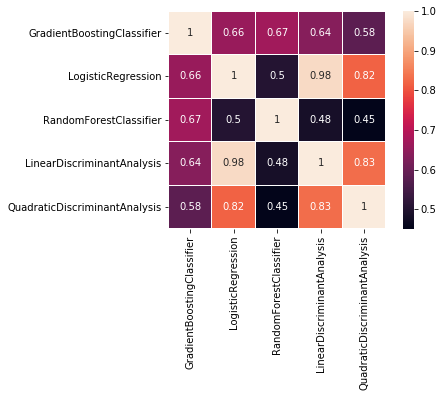

In [11]:
# data = [
#     go.Heatmap(
#         z= base_predictions_train.astype(float).corr().values ,
#         x=base_predictions_train.columns.values,
#         y= base_predictions_train.columns.values,
#           colorscale='Viridis',
#             showscale=True,
#             reversescale = True
#     )
# ]
# py.iplot(data, filename='labelled-heatmap')

sns.heatmap(second_predictions_train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True,  linecolor='white', annot=True)

In [12]:
import xgboost as xgb
print ('Choose Best Ensemble Classifier')

classifiers = [
    xgb.XGBClassifier(
    #learning_rate = 0.02,
     n_estimators= 2000,
     max_depth= 4,
     min_child_weight= 2,
     #gamma=1,
     gamma=0.9,                        
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'binary:logistic',
     nthread= -1,
     scale_pos_weight=1),
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]
x_train=second_predictions_train.values
x_test=second_predictions_test.values
acc_dict=AlgoAssemTools.eval_clfs_accuracy_score(classifiers,x_train,y_train)
log_df=pd.DataFrame({'classifier':acc_dict.keys(),'acc_score':acc_dict.values()})
log_df['classifier_name']=log_df['classifier'].apply(lambda x:x.__class__.__name__)
log_df=log_df.sort_values(['acc_score'],ascending=False)
print 'Top 3 Classifier '
print log_df['classifier_name'].head(3)


Choose Best Ensemble Classifier
Top 3 Classifier 
7     RandomForestClassifier
10                GaussianNB
1              XGBClassifier
Name: classifier_name, dtype: object


In [13]:
# Generate Submission File 
print ('Best Ensemble Classifier Results')
for i in range(0,3):
    candidate_classifier = log_df.iloc[i]['classifier']
    acc_score=log_df.iloc[i]['acc_score']
    print ('start:',candidate_classifier.__class__.__name__)
    predictions=candidate_classifier.fit(x_train,y_train).predict(x_test)
    data_test_org['Survived']=predictions
    data_test_org[['PassengerId','Survived']].to_csv("{3}/ensembleResultT_{0}_{1}_{2}.csv".format( \
        i,candidate_classifier.__class__.__name__,int(acc_score*10000),FILE_DIR),index=False)


Best Ensemble Classifier Results
('start:', 'RandomForestClassifier')
('start:', 'GaussianNB')
('start:', 'XGBClassifier')


In [14]:
from sklearn import linear_model

# fit到RandomForestRegressor之中
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
# clf.fit(X, y)
bagging_clf = BaggingRegressor(clf, n_estimators=20, max_samples=0.8, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=-1)
bagging_clf.fit(x_train,y_train)
predictions = bagging_clf.predict(x_test)
result = pd.DataFrame({'PassengerId':data_test_org['PassengerId'], 'Survived':predictions.astype(np.int32)})
result.to_csv("{0}/logistic_regression_predictions.csv".format(FILE_DIR), index=False)


In [15]:
# print list(train_df.columns)
# print pd.DataFrame({"columns":list(train_df.columns)[1:], "coef":list(clf.coef_.T)})

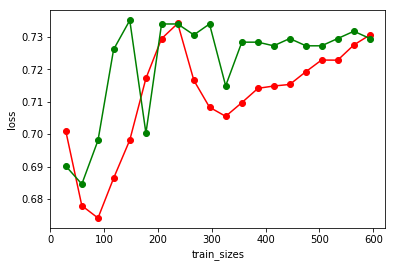

In [16]:
#判断是否过拟合
train_sizes,train_loss,test_loss=learning_curve(clf,x_train,y_train,train_sizes=np.linspace(0.05,1,20))

train_loss_mean=np.mean(train_loss,axis=1)
test_loss_mean=np.mean(test_loss,axis=1)

plt.plot(train_sizes,train_loss_mean,'o-',color='r',label='train_loss_mean')
plt.plot(train_sizes,test_loss_mean,'o-',color='g',label='test_loss_mean')
plt.xlabel('train_sizes')
plt.ylabel('loss')
plt.show()